In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Input,Model
from tensorflow.keras.callbacks import ModelCheckpoint


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 390

In [4]:

def load_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    resized_image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    final_image = resized_image / 255.0
    return final_image


def data_generator(low_light_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    #image transfer to model is tough if dataset is too big so load in pipeline in batch
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


In [5]:
train_low_light_images = sorted(glob("/content/drive/MyDrive/image_denoising/dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("/content/drive/MyDrive/image_denoising/dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
# above images are splitted in two parts train -> [0 to max] and val -> [max to last]
test_low_light_images = sorted(glob("/content/drive/MyDrive/image_denoising/dataset/eval15/low/*"))


In [6]:

# dataset created
train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

In [7]:
def build_dce():
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_img)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_img, outputs=x_r)

In [9]:
model = build_dce()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 32)       9248      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, None, None, 32)       9248      ['conv2d_1[0][0]']            
                                                                                              

In [10]:

def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mean_r, mean_g, mean_b = mean_rgb[:, :, :, 0], mean_rgb[:, :, :, 1], mean_rgb[:, :, :, 2]
    diff_rg = tf.square(mean_r - mean_g)
    diff_rb = tf.square(mean_r - mean_b)
    diff_gb = tf.square(mean_b - mean_g)
    return tf.sqrt(tf.square(diff_rg) + tf.square(diff_rb) + tf.square(diff_gb))

In [12]:
def exposure_control_loss(x, mean_val=0.6):    #after experimentation we took mean_val (E=0.6)
    mean_x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(mean_x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))

In [13]:
def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    height_x = tf.shape(x)[1]
    width_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : height_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : width_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size

In [14]:
class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLoss, self).__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):

        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_right = tf.nn.conv2d(
            original_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down




In [15]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.dce_model = build_dce()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_control_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )
        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )


In [16]:
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/image_denoising/checkpoint/model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [17]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=1e-4)

history = zero_dce_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[checkpoint_callback]
)

Epoch 1/50
24/24 [==============================] - ETA: 0s - total_loss: 5.7208 - illumination_smoothness_loss: 2.7931 - spatial_constancy_loss: 7.3689e-05 - color_constancy_loss: 0.0029 - exposure_loss: 2.9247

24/24 [==============================] - 26s 322ms/step - total_loss: 5.7389 - illumination_smoothness_loss: 2.8062 - spatial_constancy_loss: 7.1303e-05 - color_constancy_loss: 0.0029 - exposure_loss: 2.9297 - val_total_loss: 5.4491 - val_illumination_smoothness_loss: 2.3305 - val_spatial_constancy_loss: 4.4072e-05 - val_color_constancy_loss: 4.3487e-04 - val_exposure_loss: 3.1181
Epoch 2/50
24/24 [==============================] - ETA: 0s - total_loss: 4.6823 - illumination_smoothness_loss: 1.7586 - spatial_constancy_loss: 6.2448e-05 - color_constancy_loss: 0.0029 - exposure_loss: 2.9207

24/24 [==============================] - 7s 307ms/step - total_loss: 4.7043 - illumination_smoothness_loss: 1.7759 - spatial_constancy_loss: 6.0801e-05 - color_constancy_loss: 0.0028 - exposure_loss: 2.9255 - val_total_loss: 4.5777 - val_illumination_smoothness_loss: 1.4649 - val_spatial_constancy_loss: 5.0145e-05 - val_color_constancy_loss: 4.2274e-04 - val_exposure_loss: 3.1123
Epoch 3/50
24/24 [==============================] - ETA: 0s - total_loss: 4.1358 - illumination_smoothness_loss: 1.2222 - spatial_constancy_loss: 8.6122e-05 - color_constancy_loss: 0.0030 - exposure_loss: 2.9106

24/24 [==============================] - 7s 282ms/step - total_loss: 4.1563 - illumination_smoothness_loss: 1.2378 - spatial_constancy_loss: 8.4048e-05 - color_constancy_loss: 0.0029 - exposure_loss: 2.9154 - val_total_loss: 4.0986 - val_illumination_smoothness_loss: 0.9933 - val_spatial_constancy_loss: 6.9743e-05 - val_color_constancy_loss: 4.2159e-04 - val_exposure_loss: 3.1048
Epoch 4/50
24/24 [==============================] - ETA: 0s - total_loss: 3.8000 - illumination_smoothness_loss: 0.8963 - spatial_constancy_loss: 1.1398e-04 - color_constancy_loss: 0.0031 - exposure_loss: 2.9005

24/24 [==============================] - 7s 281ms/step - total_loss: 3.8182 - illumination_smoothness_loss: 0.9096 - spatial_constancy_loss: 1.1138e-04 - color_constancy_loss: 0.0030 - exposure_loss: 2.9054 - val_total_loss: 3.8109 - val_illumination_smoothness_loss: 0.7126 - val_spatial_constancy_loss: 8.8097e-05 - val_color_constancy_loss: 4.2679e-04 - val_exposure_loss: 3.0978
Epoch 5/50
24/24 [==============================] - ETA: 0s - total_loss: 3.5797 - illumination_smoothness_loss: 0.6861 - spatial_constancy_loss: 1.4550e-04 - color_constancy_loss: 0.0032 - exposure_loss: 2.8902

24/24 [==============================] - 8s 334ms/step - total_loss: 3.5960 - illumination_smoothness_loss: 0.6976 - spatial_constancy_loss: 1.4250e-04 - color_constancy_loss: 0.0032 - exposure_loss: 2.8951 - val_total_loss: 3.6311 - val_illumination_smoothness_loss: 0.5412 - val_spatial_constancy_loss: 1.1511e-04 - val_color_constancy_loss: 4.3744e-04 - val_exposure_loss: 3.0894
Epoch 6/50
24/24 [==============================] - ETA: 0s - total_loss: 3.4297 - illumination_smoothness_loss: 0.5484 - spatial_constancy_loss: 1.9355e-04 - color_constancy_loss: 0.0034 - exposure_loss: 2.8777

24/24 [==============================] - 7s 309ms/step - total_loss: 3.4444 - illumination_smoothness_loss: 0.5583 - spatial_constancy_loss: 1.8986e-04 - color_constancy_loss: 0.0033 - exposure_loss: 2.8826 - val_total_loss: 3.5119 - val_illumination_smoothness_loss: 0.4318 - val_spatial_constancy_loss: 1.5598e-04 - val_color_constancy_loss: 4.5373e-04 - val_exposure_loss: 3.0795
Epoch 7/50
24/24 [==============================] - ETA: 0s - total_loss: 3.3207 - illumination_smoothness_loss: 0.4530 - spatial_constancy_loss: 2.5817e-04 - color_constancy_loss: 0.0035 - exposure_loss: 2.8639

24/24 [==============================] - 7s 288ms/step - total_loss: 3.3341 - illumination_smoothness_loss: 0.4616 - spatial_constancy_loss: 2.5339e-04 - color_constancy_loss: 0.0034 - exposure_loss: 2.8689 - val_total_loss: 3.4271 - val_illumination_smoothness_loss: 0.3572 - val_spatial_constancy_loss: 2.0447e-04 - val_color_constancy_loss: 4.7466e-04 - val_exposure_loss: 3.0692
Epoch 8/50
24/24 [==============================] - ETA: 0s - total_loss: 3.2366 - illumination_smoothness_loss: 0.3835 - spatial_constancy_loss: 3.3913e-04 - color_constancy_loss: 0.0037 - exposure_loss: 2.8491

24/24 [==============================] - 7s 310ms/step - total_loss: 3.2489 - illumination_smoothness_loss: 0.3909 - spatial_constancy_loss: 3.3303e-04 - color_constancy_loss: 0.0036 - exposure_loss: 2.8541 - val_total_loss: 3.3614 - val_illumination_smoothness_loss: 0.3026 - val_spatial_constancy_loss: 2.6544e-04 - val_color_constancy_loss: 4.9772e-04 - val_exposure_loss: 3.0581
Epoch 9/50
24/24 [==============================] - ETA: 0s - total_loss: 3.1687 - illumination_smoothness_loss: 0.3314 - spatial_constancy_loss: 4.3948e-04 - color_constancy_loss: 0.0038 - exposure_loss: 2.8331

24/24 [==============================] - 7s 292ms/step - total_loss: 3.1801 - illumination_smoothness_loss: 0.3378 - spatial_constancy_loss: 4.3180e-04 - color_constancy_loss: 0.0037 - exposure_loss: 2.8381 - val_total_loss: 3.3098 - val_illumination_smoothness_loss: 0.2631 - val_spatial_constancy_loss: 3.4097e-04 - val_color_constancy_loss: 5.2456e-04 - val_exposure_loss: 3.0459
Epoch 10/50
24/24 [==============================] - ETA: 0s - total_loss: 3.1113 - illumination_smoothness_loss: 0.2912 - spatial_constancy_loss: 5.6249e-04 - color_constancy_loss: 0.0040 - exposure_loss: 2.8156

24/24 [==============================] - 8s 321ms/step - total_loss: 3.1220 - illumination_smoothness_loss: 0.2969 - spatial_constancy_loss: 5.5294e-04 - color_constancy_loss: 0.0039 - exposure_loss: 2.8206 - val_total_loss: 3.2673 - val_illumination_smoothness_loss: 0.2337 - val_spatial_constancy_loss: 4.3209e-04 - val_color_constancy_loss: 5.5723e-04 - val_exposure_loss: 3.0326
Epoch 11/50
24/24 [==============================] - ETA: 0s - total_loss: 3.0611 - illumination_smoothness_loss: 0.2593 - spatial_constancy_loss: 7.0885e-04 - color_constancy_loss: 0.0042 - exposure_loss: 2.7969

24/24 [==============================] - 8s 312ms/step - total_loss: 3.0711 - illumination_smoothness_loss: 0.2643 - spatial_constancy_loss: 6.9720e-04 - color_constancy_loss: 0.0041 - exposure_loss: 2.8019 - val_total_loss: 3.2306 - val_illumination_smoothness_loss: 0.2110 - val_spatial_constancy_loss: 5.4065e-04 - val_color_constancy_loss: 5.9507e-04 - val_exposure_loss: 3.0185
Epoch 12/50
24/24 [==============================] - ETA: 0s - total_loss: 3.0160 - illumination_smoothness_loss: 0.2336 - spatial_constancy_loss: 8.7916e-04 - color_constancy_loss: 0.0044 - exposure_loss: 2.7771

24/24 [==============================] - 7s 293ms/step - total_loss: 3.0254 - illumination_smoothness_loss: 0.2380 - spatial_constancy_loss: 8.6525e-04 - color_constancy_loss: 0.0044 - exposure_loss: 2.7822 - val_total_loss: 3.1978 - val_illumination_smoothness_loss: 0.1932 - val_spatial_constancy_loss: 6.6850e-04 - val_color_constancy_loss: 6.3940e-04 - val_exposure_loss: 3.0033
Epoch 13/50
24/24 [==============================] - ETA: 0s - total_loss: 2.9741 - illumination_smoothness_loss: 0.2126 - spatial_constancy_loss: 0.0011 - color_constancy_loss: 0.0047 - exposure_loss: 2.7558

24/24 [==============================] - 7s 296ms/step - total_loss: 2.9830 - illumination_smoothness_loss: 0.2165 - spatial_constancy_loss: 0.0011 - color_constancy_loss: 0.0046 - exposure_loss: 2.7609 - val_total_loss: 3.1679 - val_illumination_smoothness_loss: 0.1798 - val_spatial_constancy_loss: 8.2774e-04 - val_color_constancy_loss: 6.9122e-04 - val_exposure_loss: 2.9865
Epoch 14/50
24/24 [==============================] - ETA: 0s - total_loss: 2.9338 - illumination_smoothness_loss: 0.1953 - spatial_constancy_loss: 0.0013 - color_constancy_loss: 0.0050 - exposure_loss: 2.7322

24/24 [==============================] - 7s 303ms/step - total_loss: 2.9423 - illumination_smoothness_loss: 0.1988 - spatial_constancy_loss: 0.0013 - color_constancy_loss: 0.0049 - exposure_loss: 2.7373 - val_total_loss: 3.1394 - val_illumination_smoothness_loss: 0.1702 - val_spatial_constancy_loss: 0.0010 - val_color_constancy_loss: 7.5301e-04 - val_exposure_loss: 2.9675
Epoch 15/50
24/24 [==============================] - ETA: 0s - total_loss: 2.8927 - illumination_smoothness_loss: 0.1810 - spatial_constancy_loss: 0.0017 - color_constancy_loss: 0.0053 - exposure_loss: 2.7047

24/24 [==============================] - 8s 319ms/step - total_loss: 2.9008 - illumination_smoothness_loss: 0.1842 - spatial_constancy_loss: 0.0016 - color_constancy_loss: 0.0053 - exposure_loss: 2.7096 - val_total_loss: 3.1107 - val_illumination_smoothness_loss: 0.1650 - val_spatial_constancy_loss: 0.0013 - val_color_constancy_loss: 8.3477e-04 - val_exposure_loss: 2.9435
Epoch 16/50
24/24 [==============================] - ETA: 0s - total_loss: 2.8471 - illumination_smoothness_loss: 0.1708 - spatial_constancy_loss: 0.0022 - color_constancy_loss: 0.0058 - exposure_loss: 2.6683

24/24 [==============================] - 8s 319ms/step - total_loss: 2.8547 - illumination_smoothness_loss: 0.1739 - spatial_constancy_loss: 0.0021 - color_constancy_loss: 0.0058 - exposure_loss: 2.6729 - val_total_loss: 3.0776 - val_illumination_smoothness_loss: 0.1656 - val_spatial_constancy_loss: 0.0018 - val_color_constancy_loss: 9.7271e-04 - val_exposure_loss: 2.9092
Epoch 17/50
24/24 [==============================] - ETA: 0s - total_loss: 2.7876 - illumination_smoothness_loss: 0.1671 - spatial_constancy_loss: 0.0031 - color_constancy_loss: 0.0068 - exposure_loss: 2.6106

24/24 [==============================] - 9s 380ms/step - total_loss: 2.7945 - illumination_smoothness_loss: 0.1702 - spatial_constancy_loss: 0.0031 - color_constancy_loss: 0.0067 - exposure_loss: 2.6145 - val_total_loss: 3.0294 - val_illumination_smoothness_loss: 0.1746 - val_spatial_constancy_loss: 0.0028 - val_color_constancy_loss: 0.0013 - val_exposure_loss: 2.8507
Epoch 18/50
24/24 [==============================] - ETA: 0s - total_loss: 2.6834 - illumination_smoothness_loss: 0.1767 - spatial_constancy_loss: 0.0058 - color_constancy_loss: 0.0089 - exposure_loss: 2.4921

24/24 [==============================] - 7s 291ms/step - total_loss: 2.6884 - illumination_smoothness_loss: 0.1802 - spatial_constancy_loss: 0.0058 - color_constancy_loss: 0.0088 - exposure_loss: 2.4937 - val_total_loss: 2.9220 - val_illumination_smoothness_loss: 0.1964 - val_spatial_constancy_loss: 0.0061 - val_color_constancy_loss: 0.0021 - val_exposure_loss: 2.7174
Epoch 19/50
24/24 [==============================] - ETA: 0s - total_loss: 2.3924 - illumination_smoothness_loss: 0.2126 - spatial_constancy_loss: 0.0199 - color_constancy_loss: 0.0174 - exposure_loss: 2.1426

24/24 [==============================] - 8s 314ms/step - total_loss: 2.3882 - illumination_smoothness_loss: 0.2170 - spatial_constancy_loss: 0.0203 - color_constancy_loss: 0.0177 - exposure_loss: 2.1331 - val_total_loss: 2.5387 - val_illumination_smoothness_loss: 0.2598 - val_spatial_constancy_loss: 0.0297 - val_color_constancy_loss: 0.0084 - val_exposure_loss: 2.2408
Epoch 20/50
24/24 [==============================] - ETA: 0s - total_loss: 1.6842 - illumination_smoothness_loss: 0.2775 - spatial_constancy_loss: 0.1350 - color_constancy_loss: 0.0582 - exposure_loss: 1.2134

24/24 [==============================] - 8s 315ms/step - total_loss: 1.6720 - illumination_smoothness_loss: 0.2806 - spatial_constancy_loss: 0.1381 - color_constancy_loss: 0.0592 - exposure_loss: 1.1941 - val_total_loss: 1.8401 - val_illumination_smoothness_loss: 0.2946 - val_spatial_constancy_loss: 0.1643 - val_color_constancy_loss: 0.0413 - val_exposure_loss: 1.3400
Epoch 21/50
24/24 [==============================] - ETA: 0s - total_loss: 1.3797 - illumination_smoothness_loss: 0.2702 - spatial_constancy_loss: 0.2701 - color_constancy_loss: 0.0805 - exposure_loss: 0.7589

24/24 [==============================] - 8s 316ms/step - total_loss: 1.3747 - illumination_smoothness_loss: 0.2695 - spatial_constancy_loss: 0.2680 - color_constancy_loss: 0.0801 - exposure_loss: 0.7571 - val_total_loss: 1.7606 - val_illumination_smoothness_loss: 0.2329 - val_spatial_constancy_loss: 0.1736 - val_color_constancy_loss: 0.0503 - val_exposure_loss: 1.3038
Epoch 22/50
24/24 [==============================] - ETA: 0s - total_loss: 1.3136 - illumination_smoothness_loss: 0.2095 - spatial_constancy_loss: 0.2558 - color_constancy_loss: 0.0683 - exposure_loss: 0.7800

24/24 [==============================] - 7s 297ms/step - total_loss: 1.3098 - illumination_smoothness_loss: 0.2101 - spatial_constancy_loss: 0.2545 - color_constancy_loss: 0.0683 - exposure_loss: 0.7768 - val_total_loss: 1.7278 - val_illumination_smoothness_loss: 0.2036 - val_spatial_constancy_loss: 0.1756 - val_color_constancy_loss: 0.0523 - val_exposure_loss: 1.2962
Epoch 23/50
24/24 [==============================] - ETA: 0s - total_loss: 1.2893 - illumination_smoothness_loss: 0.1905 - spatial_constancy_loss: 0.2665 - color_constancy_loss: 0.0693 - exposure_loss: 0.7631

24/24 [==============================] - 8s 311ms/step - total_loss: 1.2855 - illumination_smoothness_loss: 0.1913 - spatial_constancy_loss: 0.2650 - color_constancy_loss: 0.0694 - exposure_loss: 0.7599 - val_total_loss: 1.7059 - val_illumination_smoothness_loss: 0.1930 - val_spatial_constancy_loss: 0.1811 - val_color_constancy_loss: 0.0547 - val_exposure_loss: 1.2772
Epoch 24/50
24/24 [==============================] - ETA: 0s - total_loss: 1.2741 - illumination_smoothness_loss: 0.1761 - spatial_constancy_loss: 0.2670 - color_constancy_loss: 0.0694 - exposure_loss: 0.7616

24/24 [==============================] - 8s 316ms/step - total_loss: 1.2703 - illumination_smoothness_loss: 0.1768 - spatial_constancy_loss: 0.2656 - color_constancy_loss: 0.0694 - exposure_loss: 0.7584 - val_total_loss: 1.6910 - val_illumination_smoothness_loss: 0.1810 - val_spatial_constancy_loss: 0.1827 - val_color_constancy_loss: 0.0558 - val_exposure_loss: 1.2714
Epoch 25/50
24/24 [==============================] - ETA: 0s - total_loss: 1.2624 - illumination_smoothness_loss: 0.1652 - spatial_constancy_loss: 0.2692 - color_constancy_loss: 0.0696 - exposure_loss: 0.7583

24/24 [==============================] - 8s 318ms/step - total_loss: 1.2585 - illumination_smoothness_loss: 0.1659 - spatial_constancy_loss: 0.2677 - color_constancy_loss: 0.0697 - exposure_loss: 0.7553 - val_total_loss: 1.6783 - val_illumination_smoothness_loss: 0.1677 - val_spatial_constancy_loss: 0.1827 - val_color_constancy_loss: 0.0568 - val_exposure_loss: 1.2712
Epoch 26/50
24/24 [==============================] - ETA: 0s - total_loss: 1.2516 - illumination_smoothness_loss: 0.1552 - spatial_constancy_loss: 0.2702 - color_constancy_loss: 0.0696 - exposure_loss: 0.7565

24/24 [==============================] - 7s 291ms/step - total_loss: 1.2477 - illumination_smoothness_loss: 0.1559 - spatial_constancy_loss: 0.2686 - color_constancy_loss: 0.0697 - exposure_loss: 0.7534 - val_total_loss: 1.6657 - val_illumination_smoothness_loss: 0.1559 - val_spatial_constancy_loss: 0.1831 - val_color_constancy_loss: 0.0573 - val_exposure_loss: 1.2693
Epoch 27/50
24/24 [==============================] - ETA: 0s - total_loss: 1.2423 - illumination_smoothness_loss: 0.1466 - spatial_constancy_loss: 0.2724 - color_constancy_loss: 0.0699 - exposure_loss: 0.7533

24/24 [==============================] - 7s 291ms/step - total_loss: 1.2384 - illumination_smoothness_loss: 0.1474 - spatial_constancy_loss: 0.2708 - color_constancy_loss: 0.0700 - exposure_loss: 0.7502 - val_total_loss: 1.6573 - val_illumination_smoothness_loss: 0.1502 - val_spatial_constancy_loss: 0.1844 - val_color_constancy_loss: 0.0578 - val_exposure_loss: 1.2649
Epoch 28/50
24/24 [==============================] - ETA: 0s - total_loss: 1.2343 - illumination_smoothness_loss: 0.1394 - spatial_constancy_loss: 0.2725 - color_constancy_loss: 0.0698 - exposure_loss: 0.7527

24/24 [==============================] - 7s 311ms/step - total_loss: 1.2304 - illumination_smoothness_loss: 0.1401 - spatial_constancy_loss: 0.2710 - color_constancy_loss: 0.0699 - exposure_loss: 0.7495 - val_total_loss: 1.6488 - val_illumination_smoothness_loss: 0.1424 - val_spatial_constancy_loss: 0.1848 - val_color_constancy_loss: 0.0583 - val_exposure_loss: 1.2634
Epoch 29/50
24/24 [==============================] - ETA: 0s - total_loss: 1.2270 - illumination_smoothness_loss: 0.1324 - spatial_constancy_loss: 0.2741 - color_constancy_loss: 0.0702 - exposure_loss: 0.7503

24/24 [==============================] - 8s 315ms/step - total_loss: 1.2230 - illumination_smoothness_loss: 0.1331 - spatial_constancy_loss: 0.2726 - color_constancy_loss: 0.0703 - exposure_loss: 0.7471 - val_total_loss: 1.6407 - val_illumination_smoothness_loss: 0.1346 - val_spatial_constancy_loss: 0.1847 - val_color_constancy_loss: 0.0581 - val_exposure_loss: 1.2633
Epoch 30/50
24/24 [==============================] - ETA: 0s - total_loss: 1.2205 - illumination_smoothness_loss: 0.1262 - spatial_constancy_loss: 0.2751 - color_constancy_loss: 0.0703 - exposure_loss: 0.7490

24/24 [==============================] - 8s 319ms/step - total_loss: 1.2166 - illumination_smoothness_loss: 0.1269 - spatial_constancy_loss: 0.2734 - color_constancy_loss: 0.0703 - exposure_loss: 0.7459 - val_total_loss: 1.6353 - val_illumination_smoothness_loss: 0.1297 - val_spatial_constancy_loss: 0.1849 - val_color_constancy_loss: 0.0579 - val_exposure_loss: 1.2629
Epoch 31/50
24/24 [==============================] - ETA: 0s - total_loss: 1.2143 - illumination_smoothness_loss: 0.1207 - spatial_constancy_loss: 0.2753 - color_constancy_loss: 0.0701 - exposure_loss: 0.7482

24/24 [==============================] - 8s 317ms/step - total_loss: 1.2102 - illumination_smoothness_loss: 0.1214 - spatial_constancy_loss: 0.2737 - color_constancy_loss: 0.0702 - exposure_loss: 0.7449 - val_total_loss: 1.6270 - val_illumination_smoothness_loss: 0.1239 - val_spatial_constancy_loss: 0.1861 - val_color_constancy_loss: 0.0587 - val_exposure_loss: 1.2582
Epoch 32/50
24/24 [==============================] - ETA: 0s - total_loss: 1.2085 - illumination_smoothness_loss: 0.1153 - spatial_constancy_loss: 0.2764 - color_constancy_loss: 0.0705 - exposure_loss: 0.7463

24/24 [==============================] - 8s 313ms/step - total_loss: 1.2044 - illumination_smoothness_loss: 0.1160 - spatial_constancy_loss: 0.2749 - color_constancy_loss: 0.0706 - exposure_loss: 0.7429 - val_total_loss: 1.6198 - val_illumination_smoothness_loss: 0.1182 - val_spatial_constancy_loss: 0.1868 - val_color_constancy_loss: 0.0588 - val_exposure_loss: 1.2560
Epoch 33/50
24/24 [==============================] - ETA: 0s - total_loss: 1.2034 - illumination_smoothness_loss: 0.1105 - spatial_constancy_loss: 0.2772 - color_constancy_loss: 0.0707 - exposure_loss: 0.7450

24/24 [==============================] - 7s 293ms/step - total_loss: 1.1992 - illumination_smoothness_loss: 0.1112 - spatial_constancy_loss: 0.2756 - color_constancy_loss: 0.0708 - exposure_loss: 0.7417 - val_total_loss: 1.6151 - val_illumination_smoothness_loss: 0.1153 - val_spatial_constancy_loss: 0.1875 - val_color_constancy_loss: 0.0588 - val_exposure_loss: 1.2534
Epoch 34/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1987 - illumination_smoothness_loss: 0.1060 - spatial_constancy_loss: 0.2776 - color_constancy_loss: 0.0708 - exposure_loss: 0.7443

24/24 [==============================] - 7s 295ms/step - total_loss: 1.1945 - illumination_smoothness_loss: 0.1066 - spatial_constancy_loss: 0.2761 - color_constancy_loss: 0.0709 - exposure_loss: 0.7409 - val_total_loss: 1.6083 - val_illumination_smoothness_loss: 0.1096 - val_spatial_constancy_loss: 0.1880 - val_color_constancy_loss: 0.0592 - val_exposure_loss: 1.2515
Epoch 35/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1934 - illumination_smoothness_loss: 0.1012 - spatial_constancy_loss: 0.2783 - color_constancy_loss: 0.0709 - exposure_loss: 0.7430

24/24 [==============================] - 8s 317ms/step - total_loss: 1.1892 - illumination_smoothness_loss: 0.1019 - spatial_constancy_loss: 0.2767 - color_constancy_loss: 0.0710 - exposure_loss: 0.7396 - val_total_loss: 1.6029 - val_illumination_smoothness_loss: 0.1050 - val_spatial_constancy_loss: 0.1883 - val_color_constancy_loss: 0.0591 - val_exposure_loss: 1.2505
Epoch 36/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1891 - illumination_smoothness_loss: 0.0972 - spatial_constancy_loss: 0.2793 - color_constancy_loss: 0.0711 - exposure_loss: 0.7416

24/24 [==============================] - 7s 294ms/step - total_loss: 1.1849 - illumination_smoothness_loss: 0.0979 - spatial_constancy_loss: 0.2778 - color_constancy_loss: 0.0712 - exposure_loss: 0.7381 - val_total_loss: 1.5976 - val_illumination_smoothness_loss: 0.1016 - val_spatial_constancy_loss: 0.1892 - val_color_constancy_loss: 0.0596 - val_exposure_loss: 1.2472
Epoch 37/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1852 - illumination_smoothness_loss: 0.0934 - spatial_constancy_loss: 0.2796 - color_constancy_loss: 0.0712 - exposure_loss: 0.7409

24/24 [==============================] - 8s 315ms/step - total_loss: 1.1809 - illumination_smoothness_loss: 0.0941 - spatial_constancy_loss: 0.2780 - color_constancy_loss: 0.0713 - exposure_loss: 0.7375 - val_total_loss: 1.5926 - val_illumination_smoothness_loss: 0.0971 - val_spatial_constancy_loss: 0.1894 - val_color_constancy_loss: 0.0595 - val_exposure_loss: 1.2467
Epoch 38/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1813 - illumination_smoothness_loss: 0.0900 - spatial_constancy_loss: 0.2800 - color_constancy_loss: 0.0714 - exposure_loss: 0.7399

24/24 [==============================] - 8s 314ms/step - total_loss: 1.1771 - illumination_smoothness_loss: 0.0907 - spatial_constancy_loss: 0.2785 - color_constancy_loss: 0.0714 - exposure_loss: 0.7364 - val_total_loss: 1.5884 - val_illumination_smoothness_loss: 0.0934 - val_spatial_constancy_loss: 0.1896 - val_color_constancy_loss: 0.0597 - val_exposure_loss: 1.2457
Epoch 39/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1778 - illumination_smoothness_loss: 0.0866 - spatial_constancy_loss: 0.2806 - color_constancy_loss: 0.0714 - exposure_loss: 0.7392

24/24 [==============================] - 8s 313ms/step - total_loss: 1.1735 - illumination_smoothness_loss: 0.0873 - spatial_constancy_loss: 0.2791 - color_constancy_loss: 0.0715 - exposure_loss: 0.7356 - val_total_loss: 1.5841 - val_illumination_smoothness_loss: 0.0900 - val_spatial_constancy_loss: 0.1899 - val_color_constancy_loss: 0.0597 - val_exposure_loss: 1.2445
Epoch 40/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1746 - illumination_smoothness_loss: 0.0837 - spatial_constancy_loss: 0.2810 - color_constancy_loss: 0.0716 - exposure_loss: 0.7383

24/24 [==============================] - 7s 295ms/step - total_loss: 1.1703 - illumination_smoothness_loss: 0.0844 - spatial_constancy_loss: 0.2795 - color_constancy_loss: 0.0717 - exposure_loss: 0.7348 - val_total_loss: 1.5808 - val_illumination_smoothness_loss: 0.0869 - val_spatial_constancy_loss: 0.1900 - val_color_constancy_loss: 0.0596 - val_exposure_loss: 1.2443
Epoch 41/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1711 - illumination_smoothness_loss: 0.0803 - spatial_constancy_loss: 0.2815 - color_constancy_loss: 0.0718 - exposure_loss: 0.7376

24/24 [==============================] - 8s 320ms/step - total_loss: 1.1668 - illumination_smoothness_loss: 0.0809 - spatial_constancy_loss: 0.2800 - color_constancy_loss: 0.0718 - exposure_loss: 0.7340 - val_total_loss: 1.5749 - val_illumination_smoothness_loss: 0.0827 - val_spatial_constancy_loss: 0.1908 - val_color_constancy_loss: 0.0599 - val_exposure_loss: 1.2415
Epoch 42/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1683 - illumination_smoothness_loss: 0.0776 - spatial_constancy_loss: 0.2825 - color_constancy_loss: 0.0719 - exposure_loss: 0.7363

24/24 [==============================] - 7s 293ms/step - total_loss: 1.1640 - illumination_smoothness_loss: 0.0783 - spatial_constancy_loss: 0.2809 - color_constancy_loss: 0.0720 - exposure_loss: 0.7328 - val_total_loss: 1.5726 - val_illumination_smoothness_loss: 0.0805 - val_spatial_constancy_loss: 0.1907 - val_color_constancy_loss: 0.0599 - val_exposure_loss: 1.2415
Epoch 43/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1659 - illumination_smoothness_loss: 0.0755 - spatial_constancy_loss: 0.2825 - color_constancy_loss: 0.0719 - exposure_loss: 0.7360

24/24 [==============================] - 7s 295ms/step - total_loss: 1.1615 - illumination_smoothness_loss: 0.0761 - spatial_constancy_loss: 0.2809 - color_constancy_loss: 0.0720 - exposure_loss: 0.7324 - val_total_loss: 1.5701 - val_illumination_smoothness_loss: 0.0791 - val_spatial_constancy_loss: 0.1912 - val_color_constancy_loss: 0.0599 - val_exposure_loss: 1.2399
Epoch 44/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1634 - illumination_smoothness_loss: 0.0732 - spatial_constancy_loss: 0.2828 - color_constancy_loss: 0.0720 - exposure_loss: 0.7354

24/24 [==============================] - 8s 316ms/step - total_loss: 1.1589 - illumination_smoothness_loss: 0.0738 - spatial_constancy_loss: 0.2813 - color_constancy_loss: 0.0721 - exposure_loss: 0.7317 - val_total_loss: 1.5651 - val_illumination_smoothness_loss: 0.0749 - val_spatial_constancy_loss: 0.1916 - val_color_constancy_loss: 0.0603 - val_exposure_loss: 1.2383
Epoch 45/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1607 - illumination_smoothness_loss: 0.0707 - spatial_constancy_loss: 0.2836 - color_constancy_loss: 0.0722 - exposure_loss: 0.7342

24/24 [==============================] - 8s 314ms/step - total_loss: 1.1562 - illumination_smoothness_loss: 0.0714 - spatial_constancy_loss: 0.2821 - color_constancy_loss: 0.0723 - exposure_loss: 0.7305 - val_total_loss: 1.5641 - val_illumination_smoothness_loss: 0.0746 - val_spatial_constancy_loss: 0.1918 - val_color_constancy_loss: 0.0603 - val_exposure_loss: 1.2375
Epoch 46/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1588 - illumination_smoothness_loss: 0.0689 - spatial_constancy_loss: 0.2833 - color_constancy_loss: 0.0722 - exposure_loss: 0.7344

24/24 [==============================] - 7s 294ms/step - total_loss: 1.1543 - illumination_smoothness_loss: 0.0695 - spatial_constancy_loss: 0.2819 - color_constancy_loss: 0.0723 - exposure_loss: 0.7307 - val_total_loss: 1.5589 - val_illumination_smoothness_loss: 0.0699 - val_spatial_constancy_loss: 0.1921 - val_color_constancy_loss: 0.0604 - val_exposure_loss: 1.2366
Epoch 47/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1555 - illumination_smoothness_loss: 0.0660 - spatial_constancy_loss: 0.2843 - color_constancy_loss: 0.0723 - exposure_loss: 0.7329

24/24 [==============================] - 8s 316ms/step - total_loss: 1.1510 - illumination_smoothness_loss: 0.0666 - spatial_constancy_loss: 0.2828 - color_constancy_loss: 0.0724 - exposure_loss: 0.7292 - val_total_loss: 1.5571 - val_illumination_smoothness_loss: 0.0689 - val_spatial_constancy_loss: 0.1924 - val_color_constancy_loss: 0.0605 - val_exposure_loss: 1.2353
Epoch 48/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1535 - illumination_smoothness_loss: 0.0640 - spatial_constancy_loss: 0.2845 - color_constancy_loss: 0.0724 - exposure_loss: 0.7326

24/24 [==============================] - 7s 295ms/step - total_loss: 1.1490 - illumination_smoothness_loss: 0.0646 - spatial_constancy_loss: 0.2830 - color_constancy_loss: 0.0725 - exposure_loss: 0.7289 - val_total_loss: 1.5548 - val_illumination_smoothness_loss: 0.0672 - val_spatial_constancy_loss: 0.1927 - val_color_constancy_loss: 0.0606 - val_exposure_loss: 1.2343
Epoch 49/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1514 - illumination_smoothness_loss: 0.0620 - spatial_constancy_loss: 0.2850 - color_constancy_loss: 0.0725 - exposure_loss: 0.7320

24/24 [==============================] - 8s 317ms/step - total_loss: 1.1469 - illumination_smoothness_loss: 0.0626 - spatial_constancy_loss: 0.2835 - color_constancy_loss: 0.0726 - exposure_loss: 0.7282 - val_total_loss: 1.5535 - val_illumination_smoothness_loss: 0.0674 - val_spatial_constancy_loss: 0.1934 - val_color_constancy_loss: 0.0609 - val_exposure_loss: 1.2319
Epoch 50/50
24/24 [==============================] - ETA: 0s - total_loss: 1.1504 - illumination_smoothness_loss: 0.0610 - spatial_constancy_loss: 0.2852 - color_constancy_loss: 0.0724 - exposure_loss: 0.7317

24/24 [==============================] - 8s 313ms/step - total_loss: 1.1457 - illumination_smoothness_loss: 0.0616 - spatial_constancy_loss: 0.2837 - color_constancy_loss: 0.0725 - exposure_loss: 0.7279 - val_total_loss: 1.5490 - val_illumination_smoothness_loss: 0.0637 - val_spatial_constancy_loss: 0.1938 - val_color_constancy_loss: 0.0612 - val_exposure_loss: 1.2303


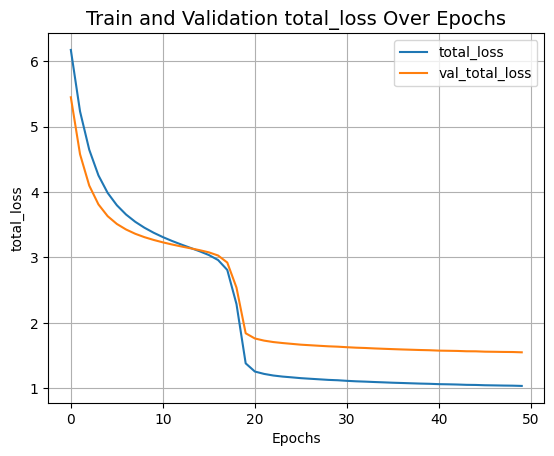

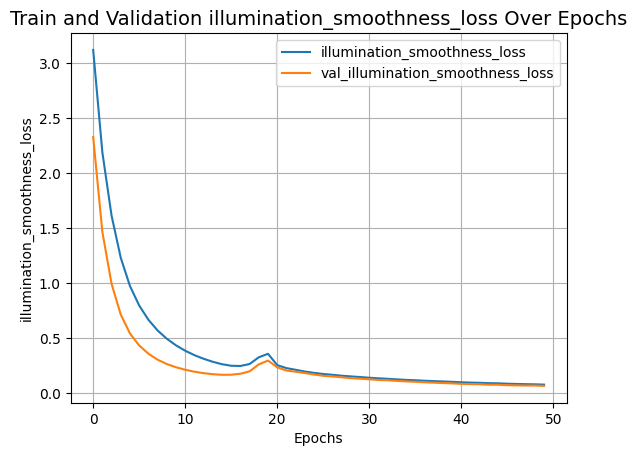

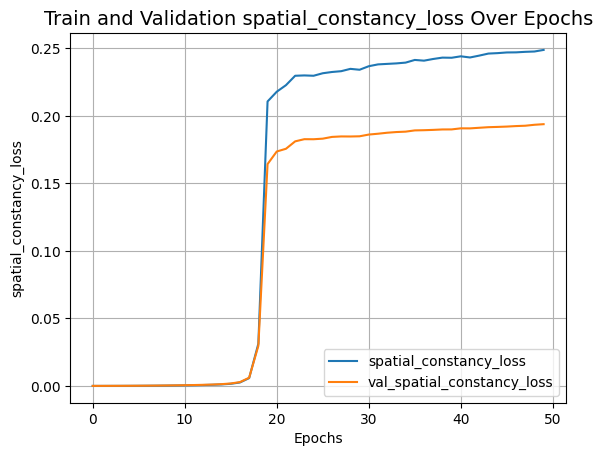

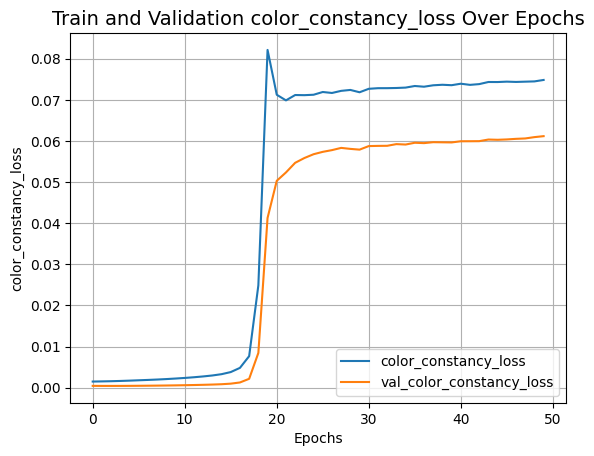

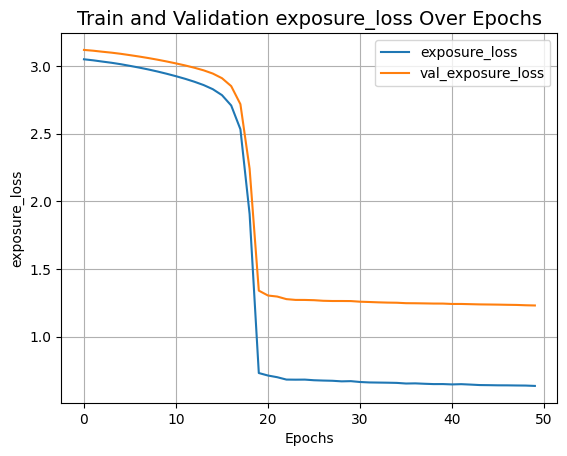

In [18]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")


In [19]:
def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    #  scaling is to be done because it was done in input
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

In [20]:
def calculate_psnr(firstImage, secondImage):
   diff = np.subtract(firstImage, secondImage)

   squared_diff = np.square(diff)

   mse = np.mean(squared_diff)      # psnr = 10*log10(max_pixel^2/mse)
                                    # mse is mean square error
   max_pixel = 255

   psnr = 20 * np.log10(max_pixel) - 10 * np.log10(mse)

   return psnr



In [ ]:
psnr_val = 0
num = len(test_low_light_images)

for val_image_file in test_low_light_images:
    new =val_image_file.replace('low','high')
    print(new)
    original_image = Image.open(val_image_file)
    new_image_np = np.array(Image.open(new))
    enhanced_image = infer(original_image)

    original_image_np = np.array(original_image)

    enhanced_image_np = np.array(enhanced_image)

    psnr_val += calculate_psnr(new_image_np, enhanced_image_np)

    plt.imshow(enhanced_image)
    plt.axis('off')
    plt.show()

psnr_val /= num
print(psnr_val)   # average psnr value

In [25]:
zero_dce_model.save_weights('/content/drive/MyDrive/image_denoising/checkpoint/model1.h5')


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/image_denoising/checkpoint/model')


In [ ]:
def infer2(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    #  scaling is to be done because it was done in input
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = new_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

In [ ]:

mse =0
num = len(test_low_light_images)

for val_image_file in test_low_light_images:
    new =val_image_file.replace('low','high')
    # print(new)
    original_image = Image.open(val_image_file)
    new_image_np = np.array(Image.open(new))
    enhanced_image = infer2(original_image)

    original_image_np = np.array(original_image)

    enhanced_image_np = np.array(enhanced_image)

    # Calculate PSNR using NumPy arrays
    # psnr_val += calculate_psnr(new_image_np, enhanced_image_np)
    # mse += np.mean(np.square(np.subtract(new_image_np,enhanced_image_np)))
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(original_image)
    axs[0].set_title('Low Light Image')
    axs[0].axis('off')
    axs[1].imshow(enhanced_image)
    axs[1].set_title('Enhanced Image')
    axs[1].axis('off')
    plt.show()


